In [1]:
ls

'2d UMAP Embedding labeled by dimension.png'
'41586_2018_63_MOESM6_ESM(AgronomicGenes).xlsx'
 amazon/
 Chromasome10/
 cmdist.npy
 connectivity
 connectivity.png
 giotto/
 heatmap
 heatmap.png
'Hierarchical Clustering.png'
 kpca2
 kpca2.png
'KPCA Embedding in 2D, Colored by 12 HDBSCAN Clusters.png'
'KPCA Embedding in 2D, Colored by 12 Hierarchical Clusters.png'
'KPCA Embedding in 2D, Colored by 12 Spectral Clusters.png'
'KPCA Embedding in 2D, Colored by Subpopulation.png'
'KPCA Embedding in 3D, Colored by 12 HDBSCAN Clusters.png'
'KPCA Embedding in 3D, Colored by 12 Hierarchical Clusters.png'
'KPCA Embedding in 3D, Colored by 12 Spectral Clusters.png'
'KPCA Embedding in 3D.png'
 local-dims
 local-dims.png
 mdist.npy
 mdist-rice.csv
 mdist-rice-decimal.csv
 mdist-Rice-GabeKJ.csv
 mds-embed-2d.npy
 mds-embed-3d.npy
 mds-embed-4d.npy
 memmap.ipynb
 metadata.csv
 plink.bed
 plink.bim
 plink.fam
 Rice3k.ipynb
 Rice3kPresentation.odp
 Rice3kPresentation.pdf
 rice-metadata.csv
 RICE_RP.tar.gz


In [3]:
#basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import DBSCAN,SpectralClustering
from sklearn.decomposition import KernelPCA
from sklearn import metrics

from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram


from gtda.mapper import (
    CubicalCover,
    make_mapper_pipeline,
    Projection,
    Eccentricity,
    plot_static_mapper_graph,
    plot_interactive_mapper_graph,
    FirstSimpleGap,
    FirstHistogramGap)

from gtda.homology import VietorisRipsPersistence
from gtda import diagrams

from gudhi.clustering.tomato import Tomato

from umap import UMAP,plot

from pandas_plink import read_plink1_bin

from sklearn.decomposition import PCA, KernelPCA

#deprecated imports

import datashader as ds
import pandas as pd
from colorcet import fire
from datashader import transfer_functions as tf

import seaborn as sns#; sns.set_theme()

from matplotlib.colors import ListedColormap


from sklearn.manifold import MDS

In [4]:
#read in files using pandas_plink
d = read_plink1_bin("plink.bed", "plink.bim", "plink.fam" , verbose=False)

In [5]:
#display summary of xarray.DataArray, this is 500mb, 23000 snps on chromasome 10 only
#for 3000 samples of rice+metdata
#d

In [6]:
label_order = d.sample.to_dataframe() #create label_order data frame
label_order.replace("_", " ", regex=True,inplace=True) #removes underscores
label_order.set_index(['sample'],inplace=True) #resets index from 'sample' column
label_order.index #print

Index(['B001', 'B002', 'B003', 'B004', 'B005', 'B006', 'B007', 'B008', 'B009',
       'B010',
       ...
       'IRIS 313-15901', 'IRIS 313-15902', 'IRIS 313-15903', 'IRIS 313-15904',
       'IRIS 313-15905', 'IRIS 313-15906', 'IRIS 313-15907', 'IRIS 313-15908',
       'IRIS 313-15909', 'IRIS 313-15910'],
      dtype='object', name='sample', length=3024)

In [7]:
metadata = pd.read_csv('varieties-4560193046506538776.csv',index_col='IRIS ID') #read metadata csv
metadata[20:40]

NAME    ACCESSION  \
IRIS ID                                                              
IRIS 313-9629                                  JC 157  IRGC 117498   
IRIS 313-8252                JAGLI BORO::IRGC 27516-2  IRGC 121233   
IRIS 313-8321                BHADOIA 303::IRGC 6588-1  IRGC 120894   
IRIS 313-8390                SUFAID 246::IRGC 28303-1  IRGC 121128   
IRIS 313-8398                 KHARSU 80::IRGC 28016-1  IRGC 121022   
IRIS 313-8410                JABOR SAIL::IRGC 66831-1  IRGC 121618   
IRIS 313-8554                 ARC 11959::IRGC 21780-1  IRGC 121188   
IRIS 313-8721   HOLOI BASH (SOLOI BASH)::IRGC 64778-1  IRGC 120969   
IRIS 313-8963                   BATHURI::IRGC 25838-1  IRGC 120887   
IRIS 313-9137                 ARC 10100::IRGC 20709-1  IRGC 121185   
IRIS 313-9283                TAK SUFAID::IRGC 73127-1  IRGC 121134   
IRIS 313-9368                CHANDARHAT::IRGC 25845-1  IRGC 121605   
IRIS 313-9422              CHUNGUR BALI::IRGC 25855-1  IRGC 120915   
IRIS 313-9610                    DANGAR::IRGC 76296-1  IRGC 120927   
IRIS 313-9626                     KALIA::IRGC 34699-1  IRGC 121005   
IRIS 313-9636              PODI HEENATI::IRGC 36345-1  IRGC 121473   
IRIS 313-9661              LENJA MURALI::IRGC 66815-1  IRGC 121038   
IRIS 313-10020               HODARAWALA::IRGC 67631-1  IRGC 120968   
IRIS 313-8253        KHAO DAWK MALI 105::IRGC 27748-2  IRGC 121235   
IRIS 313-9555                   CHUA DAU::IRGC 4785-1  IRGC 120914   

               SUBPOPULATION     COUNTRY  
IRIS ID                                   
IRIS 313-9629            aro       India  
IRIS 313-8252            aus  Bangladesh  
IRIS 313-8321            aus  Bangladesh  
IRIS 313-8390            aus    Pakistan  
IRIS 313-8398            aus    Pakistan  
IRIS 313-8410            aus  Bangladesh  
IRIS 313-8554            aus       India  
IRIS 313-8721            aus  Bangladesh  
IRIS 313-8963            aus  Bangladesh  
IRIS 313-9137            aus       India  
IRIS 313-9283            aus    Pakistan  
IRIS 313-9368            aus  Bangladesh  
IRIS 313-9422            aus  Bangladesh  
IRIS 313-9610            aus       India  
IRIS 313-9626            aus  Bangladesh  
IRIS 313-9636            aus   Sri Lanka  
IRIS 313-9661            aus  Bangladesh  
IRIS 313-10020           aus   Sri Lanka  
IRIS 313-8253           ind3    Thailand  
IRIS 313-9555           indx       China

In [8]:
metadata.loc['IRIS 313-9939']

NAME             CIWINI SML::IRGC 50642-1
ACCESSION                     IRGC 121316
SUBPOPULATION                       admix
COUNTRY                           Surinam
Name: IRIS 313-9939, dtype: object

In [9]:
metadata.index

Index(['IRIS 313-15896', 'IRIS 313-15897', 'IRIS 313-15898', 'IRIS 313-15899',
       'IRIS 313-15900', 'IRIS 313-15901', 'IRIS 313-15902', 'IRIS 313-15903',
       'IRIS 313-15904', 'IRIS 313-15905',
       ...
       'CX423', 'CX424', 'CX425', 'CX426', 'CX427', 'CX428', 'CX429', 'CX561',
       'CX578', 'CX579'],
      dtype='object', name='IRIS ID', length=3024)

In [10]:
##YOU MUST re-order the index of this metadata, from the label_order of the plink files
metadata = metadata.reindex(label_order.index)
metadata[:40] #the dataframe 'metadata' is NOW in the CORRECT order, but how to handle MISSING values?

NAME    ACCESSION SUBPOPULATION COUNTRY
sample                                                               
B001                       HEIBIAO  IRGC 135900          temp     NaN
B002                     SANSUIJIN  IRGC 136041          temp     NaN
B003                   ZAOSHENGBAI  IRGC 136088          japx     NaN
B004            QIUGUANGTENGXI 104  IRGC 136031          temp     NaN
B005                        WANSHI  IRGC 136067          temp     NaN
B006                        YIKONG  IRGC 136078          indx     NaN
B007                    TIANHANDAO  IRGC 136055          indx     NaN
B008                       BAXIANG          NaN          temp     NaN
B009                VIETNAM ZAODAO  IRGC 136065         ind1A     NaN
B010                     MALAIHONG          NaN         ind1A     NaN
B011                         CO 22  IRGC 135870          indx     NaN
B012              2037(RAJAHAMSAL)  IRGC 135815          ind2     NaN
B013                   SRI LANKA 1  IRGC 136049          indx     NaN
B014                 WUZILUOSI 215  IRGC 136072          temp     NaN
B015                        KAHAMU  IRGC 135963         ind1A     NaN
B016                  AOMIERTE 168  IRGC 135829          temp     NaN
B017                      AERJITUO  IRGC 135822          temp     NaN
B018           AMERICAN HUANGKEDAO  IRGC 135827          trop     NaN
B019                  BULEIDA A-75  IRGC 135852          indx     NaN
B020                    JINEIYADAO  IRGC 135958         admix     NaN
B021                 SELN 244A6-20  IRGC 136044          indx     NaN
B023                      GAOLIQIU  IRGC 135891          temp     NaN
B024                  XIANLUOSICHI  IRGC 136076         ind1A     NaN
B025                 DJANDA MANDJA  IRGC 135881          trop     NaN
B026    PADI LADANG ASE POLO KOMEK  IRGC 136017          indx     NaN
B027                      C 894-21  IRGC 135858          ind3     NaN
B028               IR 10179-23-1-3  IRGC 135917          indx     NaN
B029                         DUMAI  IRGC 135885         ind1B     NaN
B030                     JAIBATTEY  IRGC 135950          indx     NaN
B031                       NGATSIN  IRGC 136007          ind2     NaN
B032                        ROHINI  IRGC 136034         ind1B     NaN
B033                      BW 293-2  IRGC 135853         ind1B     NaN
B034                  ALBANIA RICE  IRGC 135825          temp     NaN
B035                 AMERICAN RICE  IRGC 135828          indx     NaN
B036                 JIJUCAS CLARO  IRGC 135955          japx     NaN
B037                    NANOAY P.A  IRGC 135999          trop     NaN
B038                NABATED A SMAR  IRGC 135997          temp     NaN
B039                       IRAT 10  IRGC 135940          indx     NaN
B040                          K 24  IRGC 135962          indx     NaN
B043                   YR 83-23-11  IRGC 136081          trop     NaN

In [11]:
metadata.loc['IRIS 313-9939']

NAME             CIWINI SML::IRGC 50642-1
ACCESSION                     IRGC 121316
SUBPOPULATION                       admix
COUNTRY                           Surinam
Name: IRIS 313-9939, dtype: object

In [12]:
country = metadata.loc[:,'COUNTRY']
unique = (pd.unique(country))
idx = np.arange(len(unique))
print(idx)
dict_country = {unique[i]: idx[i] for i in idx}
print(dict_country)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86]
{nan: 0, 'Philippines': 1, 'India': 2, 'Indonesia': 3, 'Nepal': 4, 'Sri Lanka': 5, 'Bangladesh': 6, 'Thailand': 7, 'Iran': 8, "Cote d'Ivoire": 9, 'Malaysia': 10, 'United States of America': 11, 'Madagascar': 12, 'Senegal': 13, 'Bhutan': 14, 'Viet Nam': 15, 'China': 16, 'Pakistan': 17, 'Burkina Faso': 18, 'France': 19, 'Japan': 20, 'Taiwan': 21, 'Ghana': 22, 'Nigeria': 23, 'Tanzania': 24, "Lao People's Democratic Republic": 25, 'Myanmar': 26, 'Guinea': 27, 'Guinea-Bissau': 28, 'Brazil': 29, 'Haiti': 30, 'Belgium': 31, 'Cambodia': 32, 'Venezuela': 33, 'Gambia': 34, 'Liberia': 35, 'Korea, Republic of': 36, 'Sierra Leone': 37, 'Surinam': 38, 'Brunei Darussalam': 39, 'Union of Soviet Socialist Republics (Former)': 40, "Democratic

In [13]:
#ADD a column to metadata with numeric subpop labels in the correct rows
metadata['86'] = metadata['COUNTRY'].map(dict_country)
metadata

NAME    ACCESSION SUBPOPULATION COUNTRY  \
sample                                                                        
B001                             HEIBIAO  IRGC 135900          temp     NaN   
B002                           SANSUIJIN  IRGC 136041          temp     NaN   
B003                         ZAOSHENGBAI  IRGC 136088          japx     NaN   
B004                  QIUGUANGTENGXI 104  IRGC 136031          temp     NaN   
B005                              WANSHI  IRGC 136067          temp     NaN   
...                                  ...          ...           ...     ...   
IRIS 313-15906   IR 73571-3B-11-3-K2::G1  IRGC 126963          indx     NaN   
IRIS 313-15907          INIA TACUARI::G1  IRGC 126959          trop     NaN   
IRIS 313-15908          COLOMBIA XXI::G1  IRGC 126955           aus     NaN   
IRIS 313-15909  IET 14720::IRTP 23179-G1  IRGC 126958           aro     NaN   
IRIS 313-15910    CYPRESS::IRTP 19532-G1  IRGC 126956          trop     NaN   

                86  
sample              
B001             0  
B002             0  
B003             0  
B004             0  
B005             0  
...             ..  
IRIS 313-15906   0  
IRIS 313-15907   0  
IRIS 313-15908   0  
IRIS 313-15909   0  
IRIS 313-15910   0  

[3024 rows x 5 columns]

In [14]:
metadata.loc['IRIS 313-9939']

NAME             CIWINI SML::IRGC 50642-1
ACCESSION                     IRGC 121316
SUBPOPULATION                       admix
COUNTRY                           Surinam
86                                     38
Name: IRIS 313-9939, dtype: object

In [16]:
metadata[900:920]

NAME    ACCESSION SUBPOPULATION  \
sample                                                                          
IRIS 313-8735               NEP NGAU::IRGC 78369-1  IRGC 126074          japx   
IRIS 313-8737        SADAJIRA 19-287::IRGC 38320-1  IRGC 126270          ind2   
IRIS 313-8739                  TAI 6::IRGC 69058-1  IRGC 126090         admix   
IRIS 313-8743                NIAO YAO::IRGC 5496-1  IRGC 126075          indx   
IRIS 313-8744                  REMOL::IRGC 18624-1  IRGC 126266          ind3   
IRIS 313-8745  SD 120 SELN (CI 12320)::IRGC 1667-1  IRGC 126087          trop   
IRIS 313-8747                             DOM ZARD  IRGC 117466           aro   
IRIS 313-8751                 HNANWA::IRGC 33118-1  IRGC 126209          ind3   
IRIS 313-8754                TYPE 50::IRGC 74782-1  IRGC 126011          ind2   
IRIS 313-8755                 NORIN 6::IRGC 2633-1  IRGC 126120          temp   
IRIS 313-8757                NIRGUNI::IRGC 61127-1  IRGC 126000          ind2   
IRIS 313-8765               TIMMURAY::IRGC 67857-1  IRGC 126284           aro   
IRIS 313-8767                  SIDIK::IRGC 66643-1          NaN          ind3   
IRIS 313-8768                MOROFIN::IRGC 56698-1  IRGC 127060          trop   
IRIS 313-8769                 KOSAGI::IRGC 57692-1  IRGC 126225          trop   
IRIS 313-8771            SIMUL KHURI::IRGC 35154-1  IRGC 121120           aus   
IRIS 313-8778           SUP BLUE ROSE::IRGC 1739-1  IRGC 126124          trop   
IRIS 313-8781                 TAPANG::IRGC 13361-1          NaN          ind3   
IRIS 313-8783                    105::IRGC 40896-1  IRGC 126170         admix   
IRIS 313-8785             LEUANG AWN::IRGC 48257-1          NaN          ind3   

                                COUNTRY  86  
sample                                       
IRIS 313-8735                  Viet Nam  15  
IRIS 313-8737                Bangladesh   6  
IRIS 313-8739             Cote d'Ivoire   9  
IRIS 313-8743                    Taiwan  21  
IRIS 313-8744                 Indonesia   3  
IRIS 313-8745                     Haiti  30  
IRIS 313-8747                      Iran   8  
IRIS 313-8751                   Myanmar  26  
IRIS 313-8754                     India   2  
IRIS 313-8755                     Japan  20  
IRIS 313-8757                     India   2  
IRIS 313-8765                    Bhutan  14  
IRIS 313-8767                 Indonesia   3  
IRIS 313-8768             Cote d'Ivoire   9  
IRIS 313-8769                    Guinea  27  
IRIS 313-8771                     India   2  
IRIS 313-8778  United States of America  11  
IRIS 313-8781                  Malaysia  10  
IRIS 313-8783                 Sri Lanka   5  
IRIS 313-8785                  Thailand   7

In [17]:
subpop = metadata.loc[:,'SUBPOPULATION']
unique = (np.unique(subpop))
idx = np.arange(len(unique))
print(idx)
dict12 = {unique[i]: idx[i] for i in idx}

[ 0  1  2  3  4  5  6  7  8  9 10 11]


In [18]:
metadata['12'] = metadata['SUBPOPULATION'].map(dict12)

In [19]:
metadata[900:920]

NAME    ACCESSION SUBPOPULATION  \
sample                                                                          
IRIS 313-8735               NEP NGAU::IRGC 78369-1  IRGC 126074          japx   
IRIS 313-8737        SADAJIRA 19-287::IRGC 38320-1  IRGC 126270          ind2   
IRIS 313-8739                  TAI 6::IRGC 69058-1  IRGC 126090         admix   
IRIS 313-8743                NIAO YAO::IRGC 5496-1  IRGC 126075          indx   
IRIS 313-8744                  REMOL::IRGC 18624-1  IRGC 126266          ind3   
IRIS 313-8745  SD 120 SELN (CI 12320)::IRGC 1667-1  IRGC 126087          trop   
IRIS 313-8747                             DOM ZARD  IRGC 117466           aro   
IRIS 313-8751                 HNANWA::IRGC 33118-1  IRGC 126209          ind3   
IRIS 313-8754                TYPE 50::IRGC 74782-1  IRGC 126011          ind2   
IRIS 313-8755                 NORIN 6::IRGC 2633-1  IRGC 126120          temp   
IRIS 313-8757                NIRGUNI::IRGC 61127-1  IRGC 126000          ind2   
IRIS 313-8765               TIMMURAY::IRGC 67857-1  IRGC 126284           aro   
IRIS 313-8767                  SIDIK::IRGC 66643-1          NaN          ind3   
IRIS 313-8768                MOROFIN::IRGC 56698-1  IRGC 127060          trop   
IRIS 313-8769                 KOSAGI::IRGC 57692-1  IRGC 126225          trop   
IRIS 313-8771            SIMUL KHURI::IRGC 35154-1  IRGC 121120           aus   
IRIS 313-8778           SUP BLUE ROSE::IRGC 1739-1  IRGC 126124          trop   
IRIS 313-8781                 TAPANG::IRGC 13361-1          NaN          ind3   
IRIS 313-8783                    105::IRGC 40896-1  IRGC 126170         admix   
IRIS 313-8785             LEUANG AWN::IRGC 48257-1          NaN          ind3   

                                COUNTRY  86  12  
sample                                           
IRIS 313-8735                  Viet Nam  15   8  
IRIS 313-8737                Bangladesh   6   5  
IRIS 313-8739             Cote d'Ivoire   9   0  
IRIS 313-8743                    Taiwan  21   7  
IRIS 313-8744                 Indonesia   3   6  
IRIS 313-8745                     Haiti  30  11  
IRIS 313-8747                      Iran   8   1  
IRIS 313-8751                   Myanmar  26   6  
IRIS 313-8754                     India   2   5  
IRIS 313-8755                     Japan  20  10  
IRIS 313-8757                     India   2   5  
IRIS 313-8765                    Bhutan  14   1  
IRIS 313-8767                 Indonesia   3   6  
IRIS 313-8768             Cote d'Ivoire   9  11  
IRIS 313-8769                    Guinea  27  11  
IRIS 313-8771                     India   2   2  
IRIS 313-8778  United States of America  11  11  
IRIS 313-8781                  Malaysia  10   6  
IRIS 313-8783                 Sri Lanka   5   0  
IRIS 313-8785                  Thailand   7   6

In [20]:
metadata.to_csv('metadataBaseline.csv')

In [15]:
dict11 = {'admix': 0,
 'aro': 1,
 'aus': 2,
 'ind1A': 3,
 'ind1B': 3,
 'ind2': 5,
 'ind3': 6,
 'indx': 7,
 'japx': 8,
 'subtrop': 9,
 'temp': 10,
 'trop': 11}

In [16]:
metadata['11'] = metadata['SUBPOPULATION'].map(dict11)

In [17]:
dict10 = {'admix': 0,
 'aro': 1,
 'aus': 2,
 'ind1A': 3,
 'ind1B': 3,
 'ind2': 5,
 'ind3': 6,
 'indx': 7,
 'japx': 0,
 'subtrop': 9,
 'temp': 10,
 'trop': 11}

In [18]:
metadata['10'] = metadata['SUBPOPULATION'].map(dict10)

In [19]:
dict9 = {'admix': 0,
 'aro': 1,
 'aus': 2,
 'ind1A': 3,
 'ind1B': 3,
 'ind2': 5,
 'ind3': 6,
 'indx': 0,
 'japx': 0,
 'subtrop': 9,
 'temp': 10,
 'trop': 11}

In [20]:
metadata['9'] = metadata['SUBPOPULATION'].map(dict9)

In [21]:
dict8 = {'admix': 0,
 'aro': 1,
 'aus': 2,
 'ind1A': 3,
 'ind1B': 3,
 'ind2': 5,
 'ind3': 6,
 'indx': 0,
 'japx': 0,
 'subtrop': 11,
 'temp': 10,
 'trop': 11}

In [22]:
metadata['8'] = metadata['SUBPOPULATION'].map(dict8)

In [23]:
dict6 = {'admix': 0,
 'aro': 1,
 'aus': 2,
 'ind1A': 3,
 'ind1B': 3,
 'ind2': 3,
 'ind3': 3,
 'indx': 3,
 'japx': 0,
 'subtrop': 0,
 'temp': 10,
 'trop': 11}

In [24]:
metadata['6'] = metadata['SUBPOPULATION'].map(dict6)

In [25]:
dict5 = {'admix': 0,
 'aro': 1,
 'aus': 2,
 'ind1A': 3,
 'ind1B': 3,
 'ind2': 3,
 'ind3': 3,
 'indx': 3,
 'japx': 11,
 'subtrop': 11,
 'temp': 11,
 'trop': 11}

In [26]:
metadata['5'] = metadata['SUBPOPULATION'].map(dict5)

In [27]:
dict4 = {'admix': 0,
 'aro': 11,
 'aus': 2,
 'ind1A': 3,
 'ind1B': 3,
 'ind2': 3,
 'ind3': 3,
 'indx': 3,
 'japx': 11,
 'subtrop': 11,
 'temp': 11,
 'trop': 11}

In [28]:
metadata['4'] = metadata['SUBPOPULATION'].map(dict4)

In [29]:
dict3 = {'admix': 0,
 'aro': 11,
 'aus': 3,
 'ind1A': 3,
 'ind1B': 3,
 'ind2': 3,
 'ind3': 3,
 'indx': 3,
 'japx': 11,
 'subtrop': 11,
 'temp': 11,
 'trop': 11}

In [30]:
metadata['3'] = metadata['SUBPOPULATION'].map(dict3)

In [31]:
metadata

NAME    ACCESSION SUBPOPULATION COUNTRY  \
sample                                                                        
B001                             HEIBIAO  IRGC 135900          temp     NaN   
B002                           SANSUIJIN  IRGC 136041          temp     NaN   
B003                         ZAOSHENGBAI  IRGC 136088          japx     NaN   
B004                  QIUGUANGTENGXI 104  IRGC 136031          temp     NaN   
B005                              WANSHI  IRGC 136067          temp     NaN   
...                                  ...          ...           ...     ...   
IRIS 313-15906   IR 73571-3B-11-3-K2::G1  IRGC 126963          indx     NaN   
IRIS 313-15907          INIA TACUARI::G1  IRGC 126959          trop     NaN   
IRIS 313-15908          COLOMBIA XXI::G1  IRGC 126955           aus     NaN   
IRIS 313-15909  IET 14720::IRTP 23179-G1  IRGC 126958           aro     NaN   
IRIS 313-15910    CYPRESS::IRTP 19532-G1  IRGC 126956          trop     NaN   

                86  12  11  10   9   8   6   5   4   3  
sample                                                  
B001             0  10  10  10  10  10  10  11  11  11  
B002             0  10  10  10  10  10  10  11  11  11  
B003             0   8   8   0   0   0   0  11  11  11  
B004             0  10  10  10  10  10  10  11  11  11  
B005             0  10  10  10  10  10  10  11  11  11  
...             ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  
IRIS 313-15906   0   7   7   7   0   0   3   3   3   3  
IRIS 313-15907   0  11  11  11  11  11  11  11  11  11  
IRIS 313-15908   0   2   2   2   2   2   2   2   2   3  
IRIS 313-15909   0   1   1   1   1   1   1   1  11  11  
IRIS 313-15910   0  11  11  11  11  11  11  11  11  11  

[3024 rows x 14 columns]

In [32]:
metadata.to_csv('metadata.csv')

In [33]:
metadata = pd.read_csv('metadata.csv',index_col='sample')

In [34]:
metadata

NAME    ACCESSION SUBPOPULATION COUNTRY  \
sample                                                                        
B001                             HEIBIAO  IRGC 135900          temp     NaN   
B002                           SANSUIJIN  IRGC 136041          temp     NaN   
B003                         ZAOSHENGBAI  IRGC 136088          japx     NaN   
B004                  QIUGUANGTENGXI 104  IRGC 136031          temp     NaN   
B005                              WANSHI  IRGC 136067          temp     NaN   
...                                  ...          ...           ...     ...   
IRIS 313-15906   IR 73571-3B-11-3-K2::G1  IRGC 126963          indx     NaN   
IRIS 313-15907          INIA TACUARI::G1  IRGC 126959          trop     NaN   
IRIS 313-15908          COLOMBIA XXI::G1  IRGC 126955           aus     NaN   
IRIS 313-15909  IET 14720::IRTP 23179-G1  IRGC 126958           aro     NaN   
IRIS 313-15910    CYPRESS::IRTP 19532-G1  IRGC 126956          trop     NaN   

                86  12  11  10   9   8   6   5   4   3  
sample                                                  
B001             0  10  10  10  10  10  10  11  11  11  
B002             0  10  10  10  10  10  10  11  11  11  
B003             0   8   8   0   0   0   0  11  11  11  
B004             0  10  10  10  10  10  10  11  11  11  
B005             0  10  10  10  10  10  10  11  11  11  
...             ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  
IRIS 313-15906   0   7   7   7   0   0   3   3   3   3  
IRIS 313-15907   0  11  11  11  11  11  11  11  11  11  
IRIS 313-15908   0   2   2   2   2   2   2   2   2   3  
IRIS 313-15909   0   1   1   1   1   1   1   1  11  11  
IRIS 313-15910   0  11  11  11  11  11  11  11  11  11  

[3024 rows x 14 columns]

In [35]:
#assign raw numpy array of "genotype" variable to variable g
#g = d.values
#g.shape

In [36]:
#compute a distance matrix with the listed parameters, this computation took about 1 hour in a terminal script
#cmdist = scipy.spatial.distance.pdist(g, metric='hamming')

In [37]:
#export 1-d compressed matrix called cmdist.npy
#np.save('cmdist.npy', cmdist) 

In [38]:
#reshape into a symmetric matrix
#mdist = scipy.spatial.distance.squareform(cmdist)
#check shape
#mdist.shape

In [39]:
#export full distance matrix called mdist.npy
#np.save('mdist.npy', mdist) 

In [40]:
mdist = np.load('mdist.npy')

In [41]:
#print(mdist.shape)
#print(np.amax(mdist))

save distance matrix as csv


In [42]:
#np.savetxt('mdist-rice-decimal.csv',mdist,delimiter=',',fmt='%1.6f')

In [43]:
#np.savetxt('mdist-rice.csv',mdist,delimiter=',')

In [44]:
#import distance matrix from csv as dataframe
#mdist_df = pd.read_csv('mdist-rice.csv',header=None)

In [45]:
#mdist_df

In [46]:
cmdist = np.load('cmdist.npy') #condensed mdist

In [47]:
print(cmdist.shape)
print(np.amax(cmdist))

(4570776,)
0.9920769162289682


 Laplacian Kernel

The Laplace Kernel is completely equivalent to the exponential kernel, except for being less sensitive for changes in the sigma parameter. Being equivalent, it is also a radial basis function kernel.

$k(x, y) = exp(left(- frac{lVert x-y rVert }{sigma}right)$

It is important to note that the observations made about the sigma parameter for the Gaussian kernel also apply to the Exponential and Laplacian kernels.

In [48]:
negmdist = np.negative(mdist)
negmdist

array([[-0.        , -0.10120478, -0.1504743 , ..., -0.27176128,
        -0.24148095, -0.17750527],
       [-0.10120478, -0.        , -0.14626794, ..., -0.26650642,
        -0.2366366 , -0.17102387],
       [-0.1504743 , -0.14626794, -0.        , ..., -0.28104939,
        -0.24686192, -0.17239631],
       ...,
       [-0.27176128, -0.26650642, -0.28104939, ..., -0.        ,
        -0.26403602, -0.26982255],
       [-0.24148095, -0.2366366 , -0.24686192, ..., -0.26403602,
        -0.        , -0.2361346 ],
       [-0.17750527, -0.17102387, -0.17239631, ..., -0.26982255,
        -0.2361346 , -0.        ]])

In [49]:
laplacian  = np.exp(negmdist)

In [50]:
laplacian

array([[1.        , 0.90374794, 0.86029984, ..., 0.76203615, 0.78546376,
        0.83735659],
       [0.90374794, 1.        , 0.86392619, ..., 0.76605108, 0.78927806,
        0.84280146],
       [0.86029984, 0.86392619, 1.        , ..., 0.75499105, 0.78124856,
        0.84164555],
       ...,
       [0.76203615, 0.76605108, 0.75499105, ..., 1.        , 0.76794587,
        0.76351497],
       [0.78546376, 0.78927806, 0.78124856, ..., 0.76794587, 1.        ,
        0.78967437],
       [0.83735659, 0.84280146, 0.84164555, ..., 0.76351497, 0.78967437,
        1.        ]])

If you have an affinity matrix, such as a distance matrix, for which 0 means identical elements, and high values means very dissimilar elements, it can be transformed in a similarity matrix that is well suited for the algorithm by applying the Gaussian (RBF, heat) kernel:


Where delta is a free parameter representing the width of the Gaussian kernel.

In [51]:
delta=1
gaussian = np.exp(- mdist ** 2 / (2. * delta ** 2))


In [52]:
gaussian

array([[1.        , 0.99489189, 0.98874259, ..., 0.96374639, 0.97126442,
        0.98436939],
       [0.99489189, 1.        , 0.98935986, ..., 0.96511034, 0.97238988,
        0.98548184],
       [0.98874259, 0.98935986, 1.        , ..., 0.96127536, 0.96998914,
        0.98524962],
       ...,
       [0.96374639, 0.96511034, 0.96127536, ..., 1.        , 0.96574301,
        0.96425249],
       [0.97126442, 0.97238988, 0.96998914, ..., 0.96574301, 1.        ,
        0.97250528],
       [0.98436939, 0.98548184, 0.98524962, ..., 0.96425249, 0.97250528,
        1.        ]])

## Visualizing the distance matrix

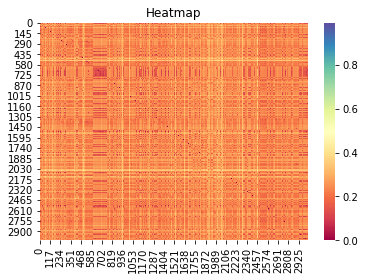

In [53]:
#Heatmap

ax = sns.heatmap(mdist,cmap='Spectral')#, vmin=0, vmax=1, center=0.8)

plt.title('Heatmap')
plt.savefig('heatmap',dpi=600)

In [54]:
#ax = sns.histogram(mdist)

# Embeddings

# KPCA

In [55]:
kpca_2d_model = KernelPCA(n_components=2, kernel='precomputed')

In [56]:
kpca2 = kpca_2d_model.fit_transform(laplacian)
kpca2[:,0].shape 

(3024,)

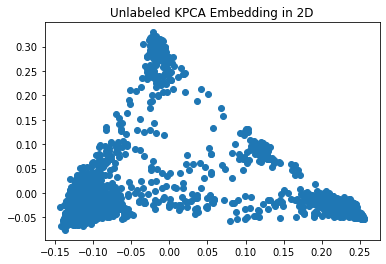

In [57]:
plt.scatter(kpca2[:,0],kpca2[:,1])

plt.title('Unlabeled KPCA Embedding in 2D')
plt.savefig('Unlabeled KPCA Embedding in 2D',dpi=600)


In [58]:
kpca_3d_model = KernelPCA(n_components=3, kernel='precomputed')

In [59]:
%time kpca_3d_embed = kpca_3d_model.fit_transform(laplacian)
kpca_3d_embed.shape 

CPU times: user 877 ms, sys: 448 ms, total: 1.32 s
Wall time: 507 ms


(3024, 3)

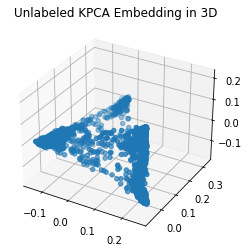

In [60]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(kpca_3d_embed[:,0],kpca_3d_embed[:,1],kpca_3d_embed[:,2])

plt.title('Unlabeled KPCA Embedding in 3D')
plt.savefig('Unlabeled KPCA Embedding in 3D',dpi=600)

# MDS Embedding

In [61]:
#mds_model_2d = MDS(n_components=2,dissimilarity='precomputed')

In [62]:
#%time mds_embed_2d = mds_model_2d.fit_transform(mdist)

In [63]:
#plt.scatter(mds_embed_2d[:,0],mds_embed_2d[:,1])

In [64]:
#np.save('mds-embed-2d.npy',mds_embed_2d)

In [65]:
mds_embed_2d = np.load('mds-embed-2d.npy')

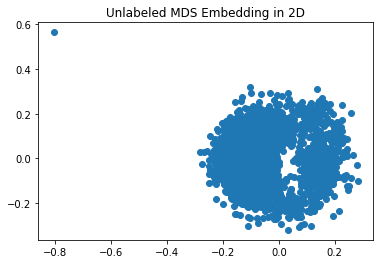

In [66]:
plt.scatter(mds_embed_2d[:,0],mds_embed_2d[:,1])

plt.title('Unlabeled MDS Embedding in 2D')
plt.savefig('Unlabeled MDS Embedding in 2D',dpi=600)

In [67]:
#mds_model_3d = MDS(n_components=3,dissimilarity='precomputed')

In [68]:
#%time mds_embed_3d = mds_model_3d.fit_transform(mdist)

In [69]:
#mds_embed_3d.shape

In [70]:
#np.save('mds-embed-3d.npy',mds_embed_3d)

In [71]:
mds_embed_3d = np.load('mds-embed-3d.npy')

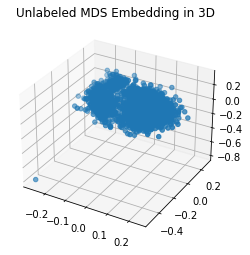

In [72]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mds_embed_3d[:,0],mds_embed_3d[:,1],mds_embed_3d[:,2])

plt.title('Unlabeled MDS Embedding in 3D')
plt.savefig('Unlabeled MDS Embedding in 3D',dpi=600)

In [73]:
#fig, ax = plt.subplots(1, 3, sharex='col', sharey='row',subplot_kw=dict(projection='3d'))
#ax[1,1].scatter(mds_embed_3d[:,0],mds_embed_3d[:,1],mds_embed_3d[:,2],c=metadata.loc[:,'k11'])


In [74]:
#mds_model_4d = MDS(n_components=4,dissimilarity='precomputed')

In [75]:
#%time mds_embed_4d = mds_model_4d.fit_transform(mdist)

In [76]:
#mds_embed_4d.shape

In [77]:
#np.save('mds-embed-4d.npy',mds_embed_4d)

In [78]:
#mds_embed_4d = np.load('mds-embed-4d.npy')

In [79]:
#fig = plt.figure()
#ax = fig.add_subplot(131, projection='3d')
#ax.scatter(mds_embed_4d[:,0],mds_embed_4d[:,1],mds_embed_4d[:,2],c=metadata.loc[:,'k11'])
#ax = fig.add_subplot(132, projection='3d')
#ax.scatter(mds_embed_4d[:,1],mds_embed_4d[:,2],mds_embed_4d[:,3],c=metadata.loc[:,'k11'])
#ax = fig.add_subplot(133, projection='3d')
#ax.scatter(mds_embed_4d[:,3],mds_embed_4d[:,1],mds_embed_4d[:,2],c=metadata.loc[:,'k11'])

In [80]:
#Create another 2-d umap dimensionality reduction embedding to visualize all unsupervised models
umap_model_2d = UMAP(metric='precomputed',min_dist=0.22)
umap_model_2d.fit(mdist)

/home/a/Desktop/ds/env/lib/python3.8/site-packages/umap/umap_.py:1503: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


UMAP(metric='precomputed', min_dist=0.22)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


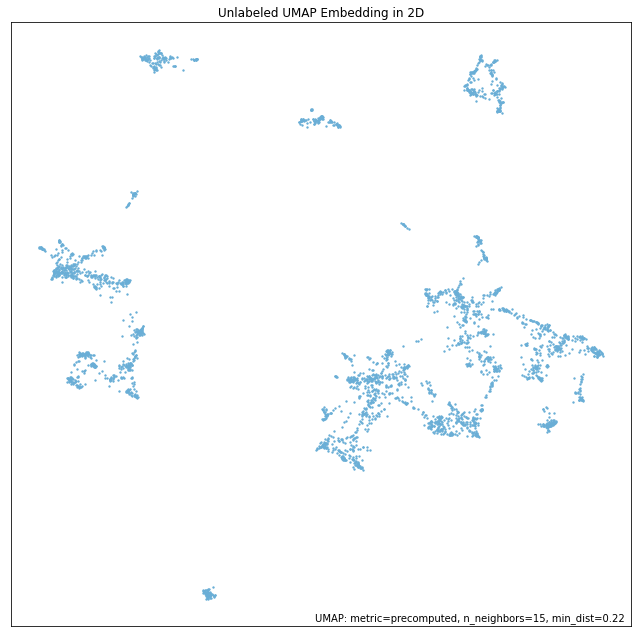

In [81]:
plot.points(umap_model_2d)

plt.title('Unlabeled UMAP Embedding in 2D')
plt.savefig('Unlabeled UMAP Embedding in 2D',dpi=600)

In [82]:
#Create a 3-d umap dimensionality reduction embedding to visualize all unsupervised models
umap_model_3d = UMAP(n_components=3,metric='precomputed',min_dist=0.16)
umap_embed_3d = umap_model_3d.fit_transform(mdist)

/home/a/Desktop/ds/env/lib/python3.8/site-packages/umap/umap_.py:1503: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


In [83]:
#Create a 3-d umap dimensionality reduction embedding to visualize all unsupervised models
umap_model_99d = UMAP(n_components=99,metric='precomputed',min_dist=0.16)
umap_embed_99d = umap_model_99d.fit_transform(mdist)

/home/a/Desktop/ds/env/lib/python3.8/site-packages/umap/umap_.py:1503: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


In [84]:
umap_embed_99d.shape

(3024, 99)

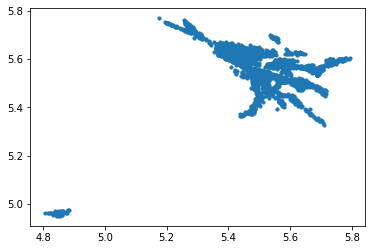

In [85]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(umap_embed_99d[:,50],umap_embed_99d[:,55],s=10)


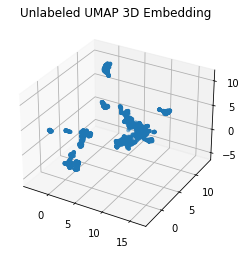

In [86]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(umap_embed_3d[:,2],umap_embed_3d[:,0],umap_embed_3d[:,1],s=10)


plt.title('Unlabeled UMAP 3D Embedding')
plt.savefig('Unlabeled UMAP 3D Embedding',dpi=600)

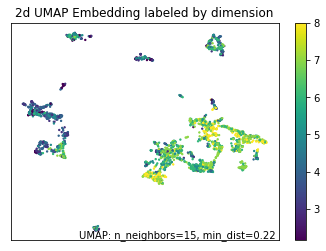

In [87]:
local_dims = plot.diagnostic(umap_model_2d, diagnostic_type='local_dim')

plt.title('2d UMAP Embedding labeled by dimension')
plt.savefig('2d UMAP Embedding labeled by dimension',dpi=600)

In [88]:
#plot.connectivity(umap_model_2d, show_points=True)
#plt.title('UMAP Connectivity Embedding')
#plt.savefig('connectivity',dpi=300)

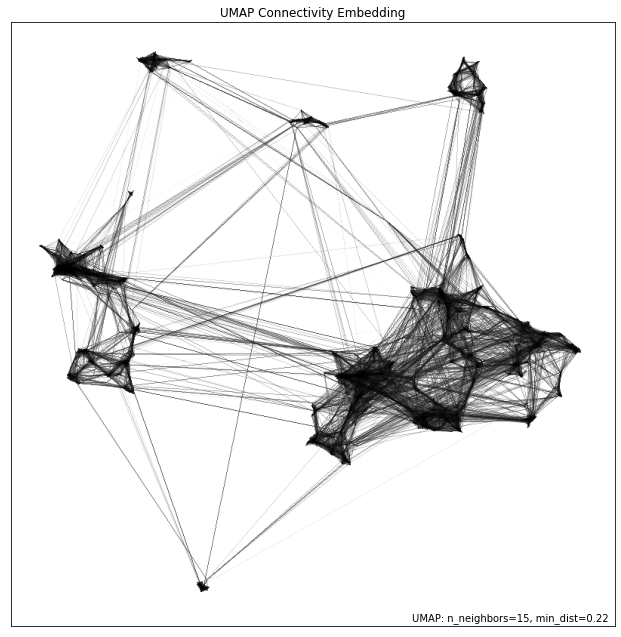

In [89]:
plot.connectivity(umap_model_2d, show_points=False, cmap="rainbow",labels=metadata["12"],)

plt.title('UMAP Connectivity Embedding')
plt.savefig('UMAP Connectivity Embedding',dpi=600)

In [90]:
#umap_embed_2d = umap_model_2d.fit_transform(mdist)


In [91]:
#umap_embed_2d_df = pd.DataFrame(umap_embed_2d)


In [92]:
#umap_embed_2d_df.columns = ['0', '1']

In [93]:
#agg = ds.Canvas().points(umap_embed_2d_df,'0','1')
#tf.set_background(tf.shade(agg, cmap=fire),"black")

# Embeddings colored by Given Labels

In [94]:
#Evaluating the given clusters
print(metrics.adjusted_rand_score(metadata.loc[:,'12'], metadata.loc[:,'12']),'is the adjusted rand score for the given labels')
print(metrics.silhouette_score(mdist, metadata.loc[:,'12'], metric='precomputed'),'is the silhoutette score for the given labels')

1.0 is the adjusted rand score for the given labels
0.07729728789257233 is the silhoutette score for the given labels


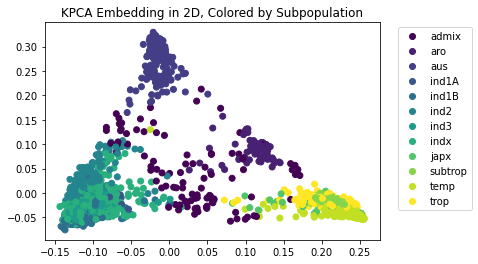

In [95]:

x, y = kpca2[:,0],kpca2[:,1]

scatter = plt.scatter(x, y,c = metadata.loc[:,'12'], cmap='viridis')
plt.legend(handles=scatter.legend_elements()[0],bbox_to_anchor=(1.04,1), loc="upper left", labels=list(dict12.keys()))

plt.title('KPCA Embedding in 2D, Colored by Subpopulation')
plt.savefig('KPCA Embedding in 2D, Colored by Subpopulation',dpi=600)

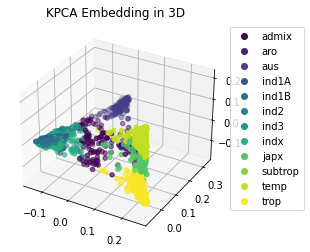

In [96]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(kpca_3d_embed[:,0],kpca_3d_embed[:,1],kpca_3d_embed[:,2],c = metadata.loc[:,'12'], cmap='viridis')
plt.legend(handles=scatter.legend_elements()[0],bbox_to_anchor=(1,1), labels=list(dict12.keys()))

plt.title('KPCA Embedding in 3D')
plt.savefig('KPCA Embedding in 3D',dpi=600)

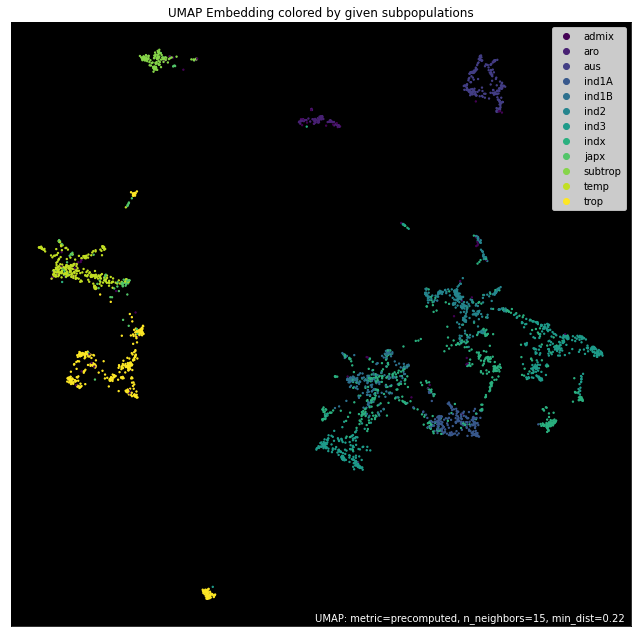

In [97]:
plot.points(umap_model_2d,labels=metadata.loc[:,'12'], color_key_cmap='viridis', background='black')
plt.legend(handles=scatter.legend_elements()[0],bbox_to_anchor=(1,1), labels=list(dict12.keys()))

plt.title('UMAP Embedding colored by given subpopulations')
plt.savefig('UMAP Embedding colored by given subpopulations')

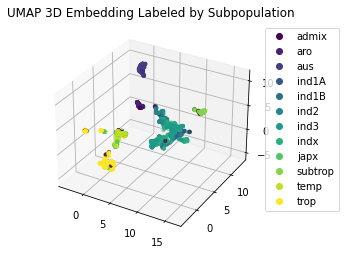

In [98]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(umap_embed_3d[:,2],umap_embed_3d[:,0],umap_embed_3d[:,1],s=10,c=metadata.loc[:,'12'])
plt.legend(handles=scatter.legend_elements()[0],bbox_to_anchor=(1,1), labels=list(dict12.keys()))


plt.title('UMAP 3D Embedding Labeled by Subpopulation')
plt.savefig('UMAP 3D Embedding Labeled by Subpopulation',dpi=600)

In [99]:
#fig = plt.figure()
#ax = fig.add_subplot(131, projection='3d')
#ax.scatter(mds_embed_3d[:,0],mds_embed_3d[:,1],mds_embed_3d[:,2],c=metadata.loc[:,'k11'])
#ax = fig.add_subplot(132, projection='3d')
#ax.scatter(mds_embed_3d[:,1],mds_embed_3d[:,2],mds_embed_3d[:,0],c=metadata.loc[:,'k11'])
#ax = fig.add_subplot(133, projection='3d')
#ax.scatter(mds_embed_3d[:,2],mds_embed_3d[:,0],mds_embed_3d[:,1],c=metadata.loc[:,'k11'])
#plt.title('3D MDS Plots')
#plt.savefig('3D MDS Plots',dpi=1200)

supervised umap

In [100]:
#Create a 2-d umap dimensionality reduction embedding with subgroup labels for supervised methods
#umap_model_2d_super = UMAP(metric='precomputed',min_dist=0.17)
#umap_model_2d_super.fit(mdist,y=metadata.loc[:,'k11'])

In [101]:
#plot.points(umap_model_2d_super,labels=metadata.loc[:,'k11'])

# Clustering Models

In [102]:
spectral_model = SpectralClustering( n_clusters=12,affinity='precomputed',assign_labels='discretize')

In [103]:
spectral_model.fit(laplacian)

SpectralClustering(affinity='precomputed', assign_labels='discretize',
                   n_clusters=12)

In [104]:
print(metrics.adjusted_rand_score(metadata.loc[:,'12'], spectral_model.labels_),'is the adjusted rand score for spectral clustering with 12 clusters')
print(metrics.silhouette_score(mdist, spectral_model.labels_, metric='precomputed'),'is the silhoutette score for spectral clustering with 12 clusters')

0.5338173627243725 is the adjusted rand score for spectral clustering with 12 clusters
0.09706246885290727 is the silhoutette score for spectral clustering with 12 clusters


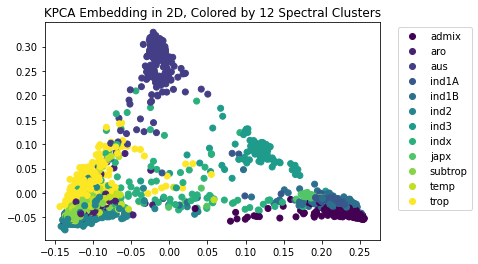

In [105]:

x, y = kpca2[:,0],kpca2[:,1]

scatter = plt.scatter(x, y,c = spectral_model.labels_, cmap='viridis')
plt.legend(handles=scatter.legend_elements()[0],bbox_to_anchor=(1.04,1), loc="upper left", labels=list(dict12.keys()))

plt.title('KPCA Embedding in 2D, Colored by 12 Spectral Clusters')
plt.savefig('KPCA Embedding in 2D, Colored by 12 Spectral Clusters',dpi=600)

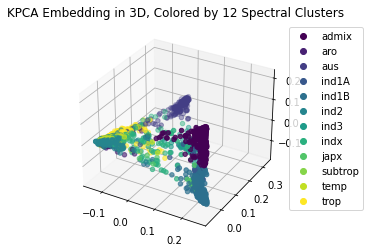

In [106]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(kpca_3d_embed[:,0],kpca_3d_embed[:,1],kpca_3d_embed[:,2],c = spectral_model.labels_, cmap='viridis')
plt.legend(handles=scatter.legend_elements()[0],bbox_to_anchor=(1,1), labels=list(dict12.keys()))

plt.title('KPCA Embedding in 3D, Colored by 12 Spectral Clusters')
plt.savefig('KPCA Embedding in 3D, Colored by 12 Spectral Clusters',dpi=600)

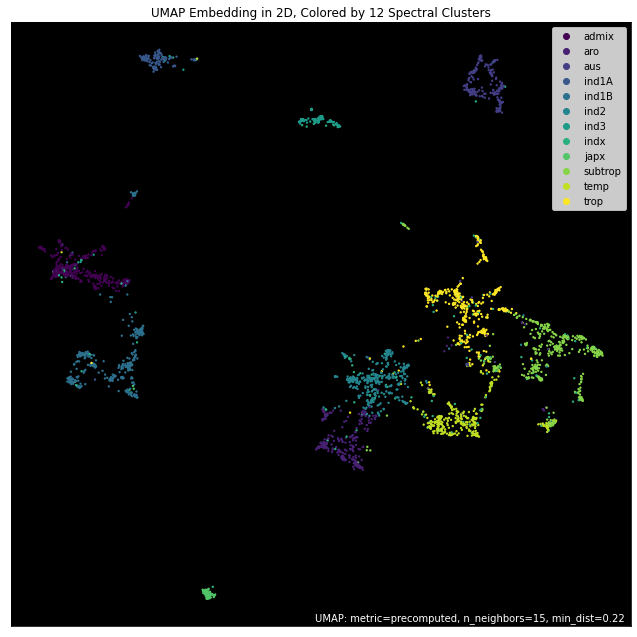

In [107]:
plot.points(umap_model_2d,labels=spectral_model.labels_,color_key_cmap='viridis', background='black')
plt.legend(handles=scatter.legend_elements()[0],bbox_to_anchor=(1,1), labels=list(dict12.keys()))

plt.title('UMAP Embedding in 2D, Colored by 12 Spectral Clusters')
plt.savefig('UMAP Embedding in 2D, Colored by 12 Spectral Clusters',dpi=600)

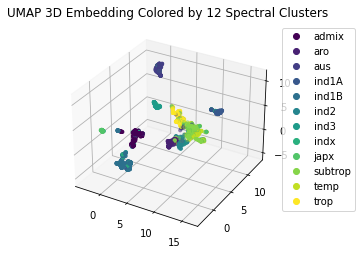

In [108]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(umap_embed_3d[:,2],umap_embed_3d[:,0],umap_embed_3d[:,1],s=10,c=spectral_model.labels_)
plt.legend(handles=scatter.legend_elements()[0],bbox_to_anchor=(1,1), labels=list(dict12.keys()))


plt.title('UMAP 3D Embedding Colored by 12 Spectral Clusters')
plt.savefig('UMAP 3D Embedding Colored by 12 Spectral Clusters',dpi=600)

In [109]:
#sns.scatterplot(kpca2[:,0],kpca2[:,1],c=spectral_model.labels_)
#plt.show()

In [110]:
#spectral_gaussian = spectral_model.fit(gaussian)

In [111]:
#np.unique(spectral_gaussian.labels_)

In [112]:
#plt.scatter(kpca2[:,0],kpca2[:,1],c=spectral_gaussian.labels_)

In [113]:
#plot.points(umap_model_2d,labels=spectral_gaussian.labels_)

In [114]:
#DBSCAN

# Hierarchical Clustering

In [115]:
from scipy.cluster.hierarchy import linkage
linkage_model = linkage(cmdist, method='ward', metric='precomputed')

In [116]:
from scipy.cluster.hierarchy import fcluster
fclusters = fcluster(linkage_model, t=12, criterion='maxclust')

In [117]:
np.unique(fclusters)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int32)

In [118]:
print(metrics.adjusted_rand_score(metadata.loc[:,'12'], fclusters),'is the adjusted rand score for hierarchical clustering with 12 labels')
print(metrics.silhouette_score(mdist, fclusters, metric='precomputed'),'is the silhoutette score for hierarchical clustering with 12 labels')

0.5418335366537841 is the adjusted rand score for hierarchical clustering with 12 labels
0.09051466321911648 is the silhoutette score for hierarchical clustering with 12 labels


In [119]:
#fig = plt.figure()

#dendrogram(linkage_model)

#plt.title('Hierarchical Clustering')
#plt.savefig('Hierarchical Clustering',dpi=600)

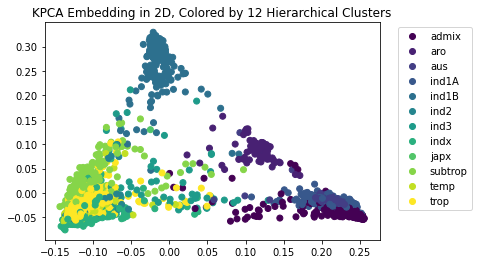

In [120]:

x, y = kpca2[:,0],kpca2[:,1]

scatter = plt.scatter(x, y,c = fclusters, cmap='viridis')
plt.legend(handles=scatter.legend_elements()[0],bbox_to_anchor=(1.04,1), loc="upper left", labels=list(dict12.keys()))

plt.title('KPCA Embedding in 2D, Colored by 12 Hierarchical Clusters')
plt.savefig('KPCA Embedding in 2D, Colored by 12 Hierarchical Clusters',dpi=600)

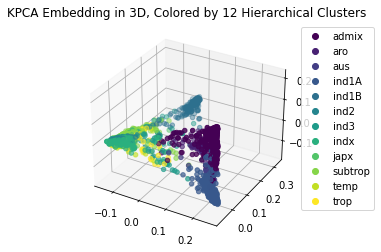

In [121]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(kpca_3d_embed[:,0],kpca_3d_embed[:,1],kpca_3d_embed[:,2],c = fclusters, cmap='viridis')
plt.legend(handles=scatter.legend_elements()[0],bbox_to_anchor=(1,1), labels=list(dict12.keys()))

plt.title('KPCA Embedding in 3D, Colored by 12 Hierarchical Clusters')
plt.savefig('KPCA Embedding in 3D, Colored by 12 Hierarchical Clusters',dpi=600)

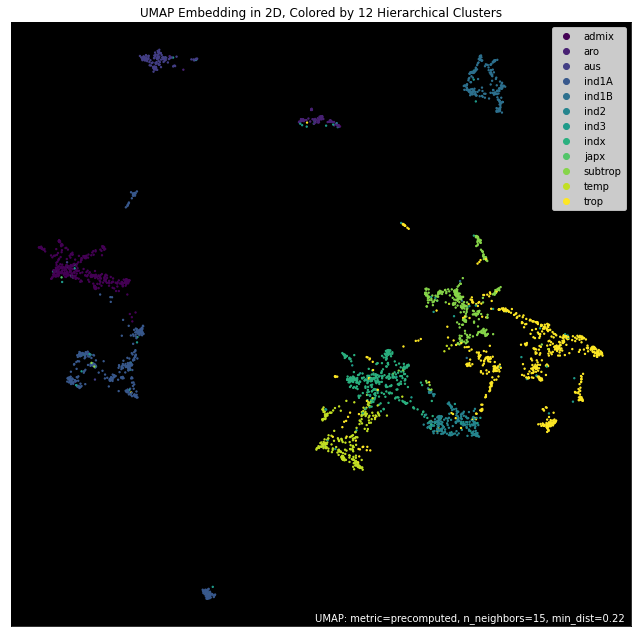

In [122]:
plot.points(umap_model_2d,labels=fclusters,color_key_cmap='viridis', background='black')
plt.legend(handles=scatter.legend_elements()[0],bbox_to_anchor=(1,1), labels=list(dict12.keys()))


plt.title('UMAP Embedding in 2D, Colored by 12 Hierarchical Clusters')
plt.savefig('UMAP Embedding in 2D, Colored by 12 Hierarchical Clusters',dpi=600)

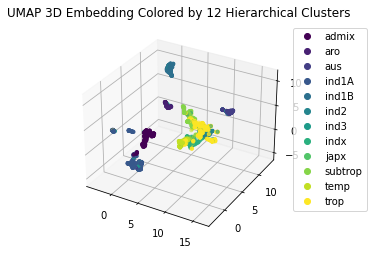

In [123]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(umap_embed_3d[:,2],umap_embed_3d[:,0],umap_embed_3d[:,1],s=10,c=fclusters)
plt.legend(handles=scatter.legend_elements()[0],bbox_to_anchor=(1,1), labels=list(dict12.keys()))


plt.title('UMAP 3D Embedding Colored by 12 Hierarchical Clusters')
plt.savefig('UMAP 3D Embedding Colored by 12 Hierarchical Clusters',dpi=600)

In [124]:
#linkage_model = linkage(cmdist, method ='weighted', metric ='precomputed')

In [125]:
#fclusters = fcluster(linkage_model, t=3, criterion='maxclust')

In [126]:
#np.unique(fclusters)

In [127]:
#plot.points(umap_model_2d,labels=fclusters)

# HDBSCAN

In [128]:
import hdbscan


hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=13,metric="precomputed",min_samples=2)
hdbscan_model.fit(mdist)


HDBSCAN(metric='precomputed', min_cluster_size=13, min_samples=2)

In [129]:
print(hdbscan_model.labels_.max())
hdbscan_model.labels_

10


array([ 9,  9, 10, ...,  0,  2,  7])

In [130]:
print(metrics.adjusted_rand_score(metadata.loc[:,'12'], hdbscan_model.labels_),'is the adjusted rand score for HDBSCAN clustering with 12 labels')
print(metrics.silhouette_score(mdist, hdbscan_model.labels_, metric='precomputed'),'is the silhoutette score for HDBSCAN clustering with 12 labels')

0.17260704774467145 is the adjusted rand score for HDBSCAN clustering with 12 labels
0.0437363935863806 is the silhoutette score for HDBSCAN clustering with 12 labels


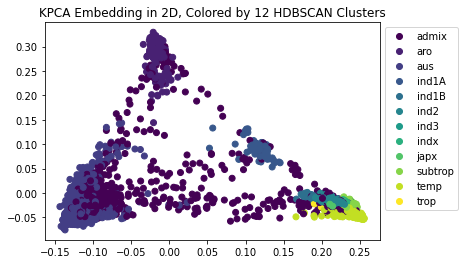

In [131]:

x, y = kpca2[:,0],kpca2[:,1]

scatter = plt.scatter(x, y,c = hdbscan_model.labels_, cmap='viridis')
plt.legend(handles=scatter.legend_elements()[0],bbox_to_anchor=(1,1), loc="upper left", labels=list(dict12.keys()))

plt.title('KPCA Embedding in 2D, Colored by 12 HDBSCAN Clusters')
plt.savefig('KPCA Embedding in 2D, Colored by 12 HDBSCAN Clusters', dpi=600)

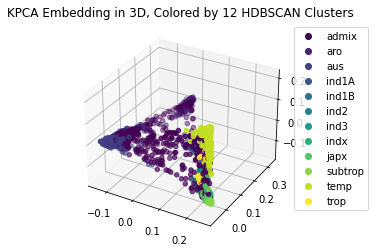

In [132]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(kpca_3d_embed[:,0],kpca_3d_embed[:,1],kpca_3d_embed[:,2],c = hdbscan_model.labels_, cmap='viridis')
plt.legend(handles=scatter.legend_elements()[0],bbox_to_anchor=(1,1), labels=list(dict12.keys()))

plt.title('KPCA Embedding in 3D, Colored by 12 HDBSCAN Clusters')
plt.savefig('KPCA Embedding in 3D, Colored by 12 HDBSCAN Clusters',dpi=600)

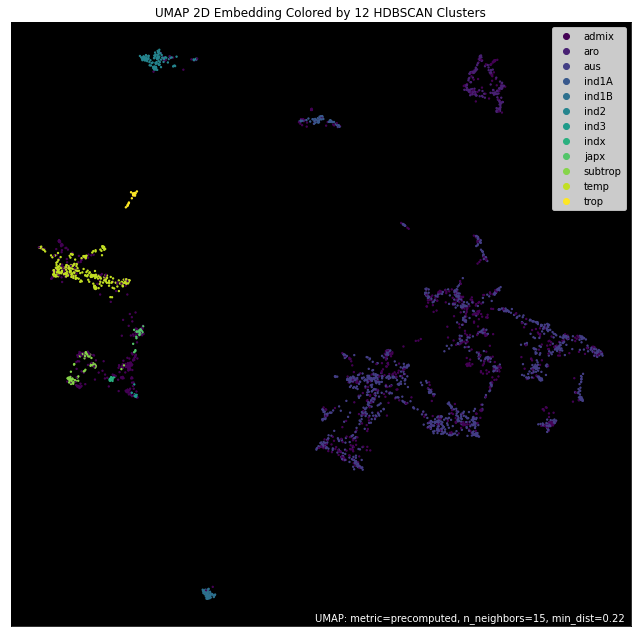

In [133]:
plot.points(umap_model_2d,labels=hdbscan_model.labels_,color_key_cmap='viridis', background='black')
plt.legend(handles=scatter.legend_elements()[0],bbox_to_anchor=(1,1), labels=list(dict12.keys()))

plt.title('UMAP 2D Embedding Colored by 12 HDBSCAN Clusters')
plt.savefig('UMAP 2D Embedding Colored by 12 HDBSCAN Clusters',dpi=600)

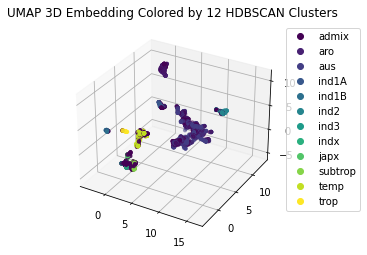

In [134]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(umap_embed_3d[:,2],umap_embed_3d[:,0],umap_embed_3d[:,1],s=10,c=hdbscan_model.labels_)
plt.legend(handles=scatter.legend_elements()[0],bbox_to_anchor=(1,1), labels=list(dict12.keys()))


plt.title('UMAP 3D Embedding Colored by 12 HDBSCAN Clusters')
plt.savefig('UMAP 3D Embedding Colored by 12 HDBSCAN Clusters',dpi=600)

In [135]:
i = 10 # We want the indices of the four largest values
idx_outliers = np.argpartition(hdbscan_model.outlier_scores_,-i)[-i:]


In [136]:
metadata.iloc[idx_outliers]

NAME    ACCESSION  \
sample                                                                   
IRIS 313-8118                      IBO 400::GERVEX 943-C1  IRGC 122085   
IRIS 313-8053                      RUBIDIO::GERVEX 146-C1  IRGC 122228   
IRIS 313-8170                   MEJANES 2::GERVEX 1560-C1  IRGC 122166   
IRIS 313-8208   LUSITO IRRADIADO 859-85-2::GERVEX 1676-C1  IRGC 122152   
B055                                                YR196  IRGC 136080   
IRIS 313-11575                  HONG PI NUO::IRGC 59638-1  IRGC 127415   
IRIS 313-8921                       PUTTIGE::IRGC 52588-1  IRGC 125879   
IRIS 313-8050                        MIARA::GERVEX 129-C1  IRGC 122170   
IRIS 313-10558                   LITCHIKIANG::IRGC 7287-1  IRGC 128367   
IRIS 313-8214                       MELAS::GERVEX 1684-C1  IRGC 122167   

               SUBPOPULATION COUNTRY  86  12  11  10   9   8   6   5   4   3  
sample                                                                        
IRIS 313-8118           temp     NaN   0  10  10  10  10  10  10  11  11  11  
IRIS 313-8053           japx     NaN   0   8   8   0   0   0   0  11  11  11  
IRIS 313-8170           japx     NaN   0   8   8   0   0   0   0  11  11  11  
IRIS 313-8208           temp     NaN   0  10  10  10  10  10  10  11  11  11  
B055                    temp     NaN   0  10  10  10  10  10  10  11  11  11  
IRIS 313-11575          temp   China  16  10  10  10  10  10  10  11  11  11  
IRIS 313-8921           temp   India   2  10  10  10  10  10  10  11  11  11  
IRIS 313-8050           temp     NaN   0  10  10  10  10  10  10  11  11  11  
IRIS 313-10558          temp   China  16  10  10  10  10  10  10  11  11  11  
IRIS 313-8214           japx     NaN   0   8   8   0   0   0   0  11  11  11

# Finding Outliers

In [137]:
#Agglomerative clustering (hierarchical clustering)
#from sklearn.cluster import AgglomerativeClustering
#agglom_model= AgglomerativeClustering(n_clusters=None, affinity='precomputed', linkage='complete', distance_threshold=.3).fit(mdist)

In [138]:
#print(agglom_model.n_clusters_)
#The number of clusters found by the algorithm. If distance_threshold=None, it will be equal to the given n_clusters.

#print(agglom_model.labels_)
#cluster labels for each point

#print(agglom_model.n_leaves_)
#Number of leaves in the hierarchical tree.

#print(agglom_model.n_connected_components_)
#The estimated number of connected components in the graph.

#print(agglom_model.children_)
#array-like of shape (n_samples-1, 2)
#The children of each non-leaf node

In [139]:
#metrics.calinski_harabasz_score(mdist, agglom_model.labels_)

In [140]:
#metrics.silhouette_score(mdist, agglom_model.labels_, metric='precomputed')

In [141]:
#metrics.adjusted_rand_score(metadata.loc[:,'k11'], agglom_model.labels_)

In [142]:
#plot.points(umap_model_2d,labels=agglom_model.labels_)

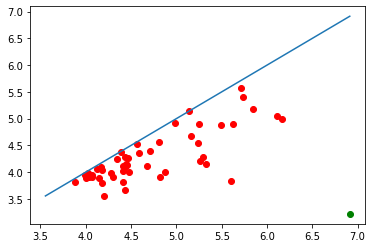

In [143]:
#ToMaTo Clustering algorithm
tom = Tomato(metric='precomputed')
tom.fit(mdist)
tom.plot_diagram()

In [144]:
print(tom.n_clusters_)
print(tom.labels_)
print(len((tom.labels_)))
print(np.unique(tom.labels_))
print(tom.weights_)

53
[ 0  0  2 ... 45 31  8]
3024
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52]
[5.23704946 5.65490248 4.66967011 ... 3.73569307 4.14502252 5.26756782]


In [145]:
metrics.calinski_harabasz_score(mdist, tom.labels_)

100.63933870664009

In [146]:
metrics.silhouette_score(mdist, tom.labels_, metric='precomputed')

0.023326325887498067

<AxesSubplot:>

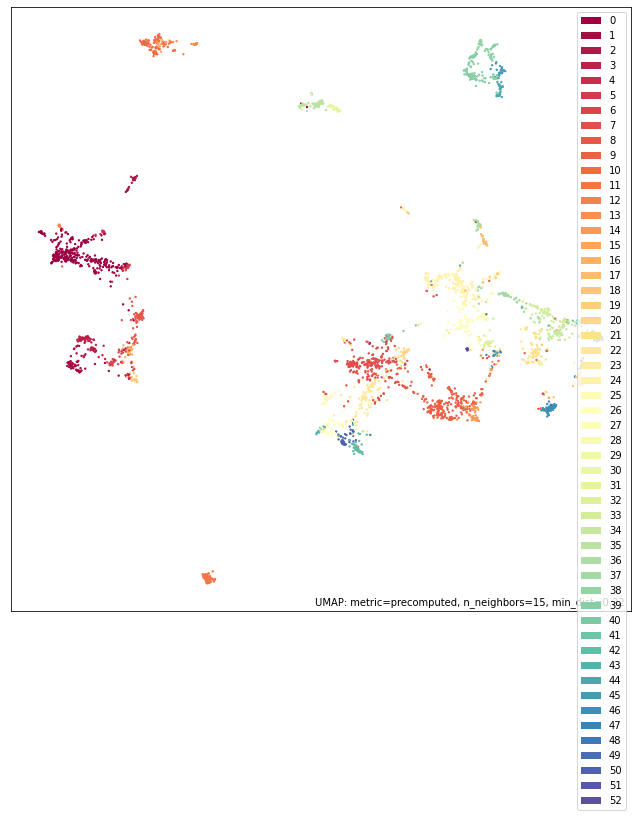

In [147]:
plot.points(umap_model_2d,labels=tom.labels_)

In [148]:
tom.n_clusters_=5

In [149]:
print(tom.n_clusters_)
print(tom.labels_)
print(len((tom.labels_)))
print(np.unique(tom.labels_))
print(tom.weights_)

5
[0 0 0 ... 1 1 1]
3024
[0 1 2 3 4]
[5.23704946 5.65490248 4.66967011 ... 3.73569307 4.14502252 5.26756782]


In [150]:
metrics.calinski_harabasz_score(mdist, tom.labels_)

627.5826304749977

In [151]:
metrics.silhouette_score(mdist, tom.labels_, metric='precomputed')

0.03695560861538429

<AxesSubplot:>

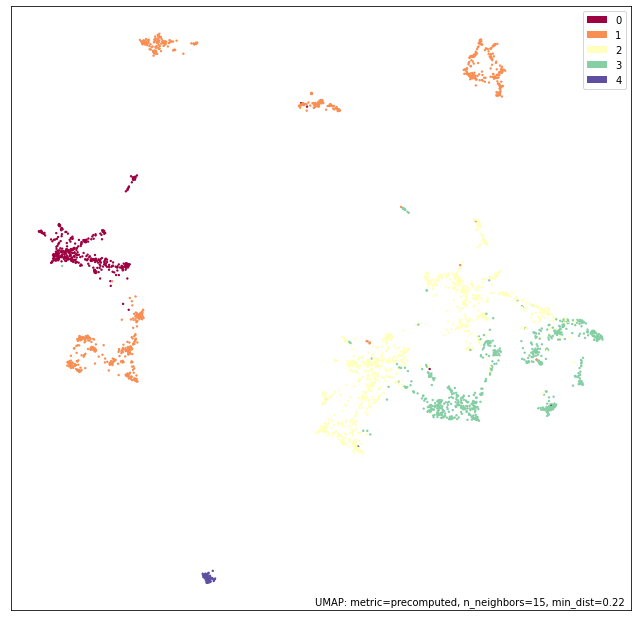

In [152]:
plot.points(umap_model_2d,labels=tom.labels_)

In [153]:
tom.n_clusters_=5

In [154]:
print(tom.n_clusters_)
print(tom.labels_)
print(len((tom.labels_)))
print(np.unique(tom.labels_))
print(tom.weights_)

5
[0 0 0 ... 1 1 1]
3024
[0 1 2 3 4]
[5.23704946 5.65490248 4.66967011 ... 3.73569307 4.14502252 5.26756782]


<AxesSubplot:>

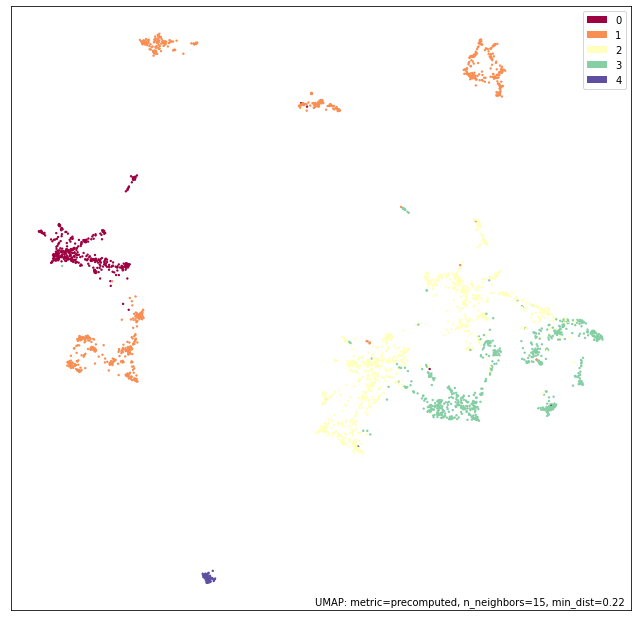

In [155]:
plot.points(umap_model_2d,labels=tom.labels_)

In [156]:
tom.n_clusters_=3

In [157]:
print(tom.n_clusters_)
print(tom.labels_)
print(len((tom.labels_)))
print(np.unique(tom.labels_))
print(tom.weights_)

3
[0 0 0 ... 1 1 1]
3024
[0 1 2]
[5.23704946 5.65490248 4.66967011 ... 3.73569307 4.14502252 5.26756782]


<AxesSubplot:>

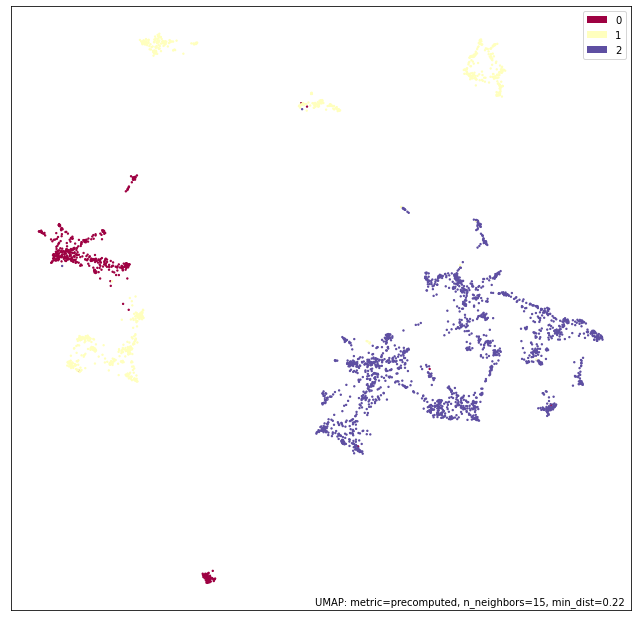

In [158]:
plot.points(umap_model_2d,labels=tom.labels_)

In [159]:
#umap_model_3d = UMAP(metric='precomputed',n_components=3)
#umap_out_3d = umap_model_3d.fit(mdist)

In [160]:
rips_model = VietorisRipsPersistence(metric='precomputed', homology_dimensions=(0, 1))

In [161]:
diagram = rips_model.fit_transform([mdist])

In [162]:
from gtda.plotting import plot_diagram

#i = 0
plot_diagram(diagram[0])

In [163]:
diagrams.PersistenceLandscape().fit_transform_plot(diagram)

array([[[0.00000000e+00, 9.99669956e-03, 1.99933991e-02, 2.99900987e-02,
         3.99867983e-02, 4.99834978e-02, 5.99801974e-02, 6.99768970e-02,
         7.99735965e-02, 8.99702961e-02, 9.99669956e-02, 1.09963695e-01,
         1.19960395e-01, 1.29957094e-01, 1.39953794e-01, 1.49950493e-01,
         1.59947193e-01, 1.69943893e-01, 1.79940592e-01, 1.89937292e-01,
         1.99933991e-01, 2.09930691e-01, 2.19927390e-01, 2.29924090e-01,
         2.39920790e-01, 2.49917489e-01, 2.59914189e-01, 2.69910888e-01,
         2.79907588e-01, 2.89904287e-01, 2.99900987e-01, 3.09897686e-01,
         3.19894386e-01, 3.29891086e-01, 3.39887785e-01, 3.49884485e-01,
         3.59881184e-01, 3.69877884e-01, 3.79874583e-01, 3.89871283e-01,
         3.99867983e-01, 4.09864682e-01, 4.19861382e-01, 4.29858081e-01,
         4.39854781e-01, 4.49851480e-01, 4.59848180e-01, 4.69844880e-01,
         4.79841579e-01, 4.89838279e-01, 4.89838279e-01, 4.79841579e-01,
         4.69844880e-01, 4.59848180e-01, 4.49851480

In [164]:
entropy = diagrams.PersistenceEntropy().fit_transform(diagram)

In [165]:
entropy

array([[11.45657304,  8.77231709]])

In [166]:
diagrams.PersistenceImage().fit_transform_plot(diagram)

array([[[[1.59171237e+01, 1.59093136e+01, 1.58859063e+01, ...,
          1.57161271e-01, 1.42817516e-01, 1.29655552e-01],
         [1.58405679e+01, 1.58327954e+01, 1.58095006e+01, ...,
          1.56405380e-01, 1.42130614e-01, 1.29031954e-01],
         [1.56131027e+01, 1.56054418e+01, 1.55824815e+01, ...,
          1.54159452e-01, 1.40089666e-01, 1.27179099e-01],
         ...,
         [3.27622184e+04, 3.27461429e+04, 3.26979635e+04, ...,
          3.23485070e+02, 2.93961317e+02, 2.66870045e+02],
         [3.04984754e+04, 3.04835107e+04, 3.04386603e+04, ...,
          3.01133499e+02, 2.73649723e+02, 2.48430354e+02],
         [2.81652259e+04, 2.81514060e+04, 2.81099869e+04, ...,
          2.78095640e+02, 2.52714477e+02, 2.29424486e+02]],

        [[5.70884999e+03, 5.86709639e+03, 6.02568235e+03, ...,
          3.50814598e+03, 3.37775031e+03, 3.25006477e+03],
         [5.71709548e+03, 5.87556873e+03, 6.03438196e+03, ...,
          3.51311893e+03, 3.38253743e+03, 3.25466997e+03],
        

In [167]:
diagrams.Filtering(homology_dimensions=None, epsilon=0.03).fit_transform_plot(diagram)

array([[[0.        , 0.0301097 , 0.        ],
        [0.        , 0.03070566, 0.        ],
        [0.        , 0.03074028, 0.        ],
        ...,
        [0.17800973, 0.2180035 , 1.        ],
        [0.16523983, 0.19769379, 1.        ],
        [0.13996705, 0.17283648, 1.        ]]])

In [168]:
first_simple_gap_model = FirstSimpleGap(linkage='average', affinity='precomputed', relative_gap_size=0.1, max_fraction=0.02, memory=None)

In [169]:
first_simple_gap_model.fit(mdist)
first_simple_gap_model.n_clusters_

2

In [170]:
pipeline = make_mapper_pipeline(filter_func=Eccentricity(metric='precomputed'), 
                                clusterer=first_simple_gap_model)



In [171]:
fig = plot_static_mapper_graph(pipeline,mdist);
fig.show()

In [172]:
first_histogram_gap_model = FirstHistogramGap(linkage='single', affinity='precomputed', freq_threshold=0, max_fraction=0.01, n_bins_start=2, memory=None)

In [173]:
first_histogram_gap_model.fit(mdist)

FirstHistogramGap(affinity='precomputed', max_fraction=0.01, n_bins_start=2)

In [174]:
first_histogram_gap_model.n_clusters_

2

In [175]:
pipeline = make_mapper_pipeline(filter_func=Eccentricity(metric='precomputed'), 
                                clusterer=first_histogram_gap_model)



In [176]:
fig = plot_static_mapper_graph(pipeline,mdist);
fig.show()

In [177]:
#pipeline.n_clusters_

In [178]:

pipeline = make_mapper_pipeline(filter_func=Eccentricity(metric='precomputed'), 
                                clusterer=DBSCAN(metric='precomputed',eps=.16,min_samples=10))


In [179]:
fig = plot_static_mapper_graph(pipeline,mdist);
fig.show()

In [180]:
pipeline = make_mapper_pipeline(filter_func=UMAP(metric='precomputed',n_neighbors=10,min_dist=.16,n_components=5),
                                clusterer=DBSCAN(metric='precomputed',eps=.16,min_samples=10))

In [181]:
fig = plot_interactive_mapper_graph(pipeline,mdist,layout_dim=2);

/home/a/Desktop/ds/env/lib/python3.8/site-packages/umap/umap_.py:1503: UserWarning:

using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data



In [182]:
fig

In [183]:
pipeline = make_mapper_pipeline(filter_func = Projection([0,1,2,3,4,5,6,7]))


In [ ]:
fig = plot_interactive_mapper_graph(pipeline,mdist,layout_dim=2);

In [ ]:
fig

In [ ]:
#plot(mapper_graph,layout = mapper_graph.layout_kamada_kawai())

In [ ]:
#test distance Metrics
#print(callable(nltk.distance.edit_distance))
#print(callable(nltk.distance.jaccard_distance))
#print(callable(nltk.distance.masi_distance))
#print(callable(nltk.distance.jaro_similarity))

#Levenshtein package requires two strings, so don't use it for now
#print(callable(Levenshtein.distance))
#print(callable(Levenshtein.hamming))

#pylev package should be tested for speed
#print(callable(pylev.levenshtein))

#The following metrics need floats
#print(callable(scipy.spatial.distance.hamming))

In [ ]:
#Try scipy clustering
from scipy.cluster.hierarchy import dendrogram, linkage
cmdist_linkage = linkage(cmdist,method='single')
cmdist_linkage.shape

In [ ]:
dendrogram(cmdist_linkage, truncate_mode="level")  

In [ ]:
cmdist_fcluster = fcluster(cmdist_linkage, t=0.28, criterion='distance')
cmdist_fcluster
np.unique(cmdist_fcluster)

In [ ]:
plot.points(umap_model_2d,labels=cmdist_fcluster, color_key_cmap='viridis', background='black')
plt.legend(handles=scatter.legend_elements()[0],bbox_to_anchor=(1,1), labels=list(dict12.keys()))
